In [2]:
# %% Import Libraries
#This is a test
import os
import pickle
import scipy.io
import numpy as np
import pandas as pd
import torch as tc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split

import ruptures as rpt
from scipy.stats import zscore

import matplotlib.patches as mpatches
from tqdm import tqdm
from bptt.models import Model
import model_anafunctions as func


plt.rcParams['font.size'] = 20

numpy.ndarray size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject


In [3]:
CP_info = {}


# Change points of Neuronal activity
CP_info["cp_mua"] = [30,70,130,170,215]+[20,50,90,145]+[15,40,120]+[30,85,140,180]+[50,80,135]
# Change points of Behaviour
CP_info["cp_beh"] = [30,70,130,170,170]+[20,65,65,65]+[30,30,115]+[30,55,140,140]+[80,80,175]
# Trial distance
CP_info["trial_distance"] = [0,0,0,0,45]+[0,15,25,80]+[15,10,5]+[0,30,0,40]+[30,0,40]
# Session
CP_info["session"] = ["DM01_7"]*5+["DM01_5"]*4+["JG15_25"]*3+["JG15_24"]*4+["CE17_L6"]*3

CP_df=pd.DataFrame(CP_info)

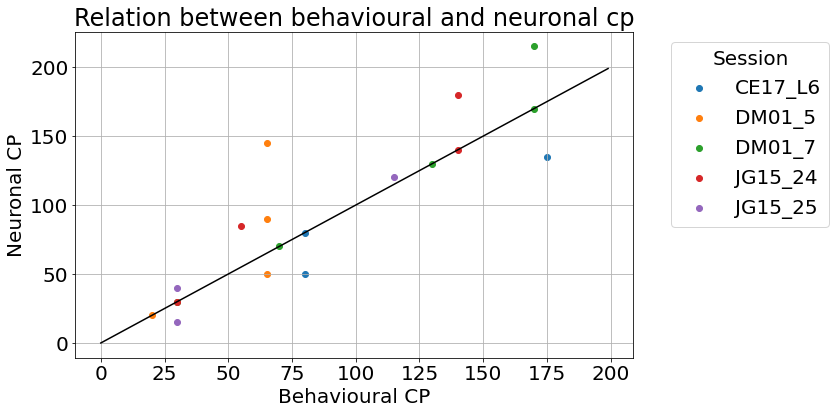

In [8]:
# Grouping the DataFrame by session
grouped = CP_df.groupby('session')

# Plotting
plt.figure(figsize=(10, 6))

for name, group in grouped:
    plt.scatter(group['cp_beh'], group['cp_mua'], label=name)
plt.plot(range(200),range(200),'k')
plt.xlabel('Behavioural CP')
plt.ylabel('Neuronal CP')
plt.title('Relation between behavioural and neuronal cp')
plt.legend(title='Session', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()